# Birds Classifications

## Definition of Transfer Learning

Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. This area of research bears some relation to the long history of psychological literature on transfer of learning, although formal ties between the two fields are limited. From the practical standpoint, reusing or transferring information from previously learned tasks for the learning of new tasks has the potential to significantly improve the sample efficiency of a reinforcement learning agent.
<br><br>
Ressource from : [Wikipedia](https://en.wikipedia.org/wiki/Transfer_learning)

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.models import Model, Sequential

# Split Data

In [2]:
# Splitting the data starts here, we store the path to the training set into a variable for further referencing.

train_path = './dataset/train'
test_path = './dataset/test'
valid_path = './dataset/valid'

birds = np.array(list(os.listdir(train_path)))

In [3]:
# pick only 20 type of birds to train on
nr_birds = 30

np.random.shuffle(birds)
# slicing the data
birds = birds[:nr_birds]

In [4]:
idx_to_name = {i:x for (i,x) in enumerate(birds)}
name_to_idx = {x:i for (i,x) in enumerate(birds)}
print(idx_to_name)

{0: 'INDIAN ROLLER', 1: 'SHOEBILL', 2: 'HOATZIN', 3: 'NORTHERN GANNET', 4: 'BIRD OF PARADISE', 5: 'IBISBILL', 6: 'EARED PITA', 7: 'SNOWY OWL', 8: 'MAGPIE GOOSE', 9: 'GREAT POTOO', 10: 'HORNBILL', 11: 'LAZULI BUNTING', 12: 'ANNAS HUMMINGBIRD', 13: 'KILLDEAR', 14: 'SCARLET MACAW', 15: 'ELEGANT TROGON', 16: 'CRESTED KINGFISHER', 17: 'GOLDEN EAGLE', 18: 'WHITE CHEEKED TURACO', 19: 'PURPLE FINCH', 20: 'BLUE HERON', 21: 'BAY-BREASTED WARBLER', 22: 'ASHY THRUSHBIRD', 23: 'CERULEAN WARBLER', 24: 'DUSKY LORY', 25: 'GOLDEN PHEASANT', 26: 'COMMON HOUSE MARTIN', 27: 'OKINAWA RAIL', 28: 'ELLIOTS  PHEASANT', 29: 'MYNA'}


In [5]:
# Function to store labels based on the folders.

def get_data_labels(path, birds, dimensions):
    data = []
    labels = []

    for bird in birds:
        imgs = [cv2.resize(cv2.imread(img), dimensions, interpolation=cv2.INTER_AREA) for img in glob.glob(path + "/" + bird + "/*.jpg")]
        for img in imgs:
            data.append(img)
            labels.append(name_to_idx[bird])
            
    return np.array(data), np.array(labels)

In [6]:
data_train, labels_train = get_data_labels(train_path, idx_to_name.values(), (224,224))
data_test, labels_test = get_data_labels(test_path, idx_to_name.values(), (224,224))
data_valid, labels_valid = get_data_labels(valid_path, idx_to_name.values(), (224,224))

print(data_train.shape)

(4289, 224, 224, 3)


In [7]:
def normalize(data):
    data = data / 255.0
    data = data.astype('float32')
    return data

def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [8]:
data_train = normalize(data_train)
data_test = normalize(data_test)
data_valid = normalize(data_valid)

labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)
labels_valid = one_hot(labels_valid)

# Architecture

# Implementation

In [9]:
weights_path = "./dataset/pre-trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_vgg16 = VGG16(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
# base_vgg16.trainable = False
base_vgg16.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-01 20:12:37.174318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 20:12:37.174456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# Freezing the weights
for layer in base_vgg16.layers:
    layer.trainable = False
 
base_vgg16.summary();

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# use “get_layer” method to save the last layer of the network
last_layer = base_vgg16.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add our new softmax layer with 3 hidden units
x = Dense(nr_birds, activation='softmax', name='softmax')(x)

In [12]:
# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_vgg16.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
checkpointer = ModelCheckpoint(filepath='birds.model.hdf5', save_best_only=True)

history = new_model.fit(data_train, labels_train, steps_per_epoch=len(data_train),
validation_data=(data_test, labels_test), validation_steps=3, epochs=30, verbose=1, callbacks=[checkpointer])

Epoch 1/30


2022-05-01 20:12:50.563281: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-01 20:12:51.253358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4288/4289 [============================>.] - ETA: 0s - loss: 1.2345 - accuracy: 0.6702

2022-05-01 20:14:50.634647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4289/4289 [==============================] - 125s 29ms/step - loss: 1.2353 - accuracy: 0.6701 - val_loss: 0.5036 - val_accuracy: 0.8600
Epoch 2/30
4289/4289 [==============================] - 236s 55ms/step - loss: 0.1841 - accuracy: 0.9550 - val_loss: 0.3578 - val_accuracy: 0.8933
Epoch 3/30
4289/4289 [==============================] - 282s 66ms/step - loss: 0.0466 - accuracy: 0.9925 - val_loss: 0.3038 - val_accuracy: 0.9133
Epoch 4/30
4289/4289 [==============================] - 280s 65ms/step - loss: 0.0221 - accuracy: 0.9972 - val_loss: 0.2186 - val_accuracy: 0.9467
Epoch 5/30
4289/4289 [==============================] - 207s 48ms/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.2607 - val_accuracy: 0.9467
Epoch 6/30
4289/4289 [==============================] - 192s 45ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.4532 - val_accuracy: 0.8800
Epoch 7/30
4289/4289 [==============================] - 183s 43ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.3644 - val

In [15]:
# Analyze Training Data

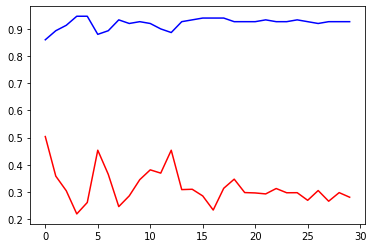

In [16]:
plt.plot(history.history['val_accuracy'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.show()

In [17]:
def get_accuracy(model, data_valid, labels_valid):
    predictions = model(data_valid)
    wrong = 0
    for i, pred in enumerate(predictions):
        if( np.argmax(pred) !=  np.argmax(labels_valid[i])):
            wrong += 1
    return (len(data_valid) - wrong) / len(data_valid)

In [18]:
# we use the validation data to verify the accuracy
accuracy = get_accuracy(new_model, data_valid, labels_valid)
print("Valid Accuracy:", accuracy)

Valid Accuracy: 0.96


In [19]:
# we use the test data to verify the accuracy
accuracy = get_accuracy(new_model, data_test, labels_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9266666666666666


In [20]:
new_model.save('birds-trained-model')

2022-05-01 21:38:08.738995: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: birds-trained-model/assets


# Resources

Architectures images from [Deep Learning for Vision Systems Book](https://www.manning.com/books/deep-learning-for-vision-systems)